In [1]:
!pip install pycm livelossplot torchvision

You should consider upgrading via the '/opt/firedrake/bin/python -m pip install --upgrade pip' command.


In [2]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from pycm import *
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor
import json

In [3]:
# AUGMENTATION AND RESIZING
augmented = 1  # 1 for on 0 for off
dimension1 = 144  # Training set dim
dimension2 = 144  # Validation set dim
batch_size = 64
test_batch_size = 1000

In [4]:
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

Available devices  4
Current cuda device  0


In [5]:
torch.cuda.set_device(1)
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

Available devices  4
Current cuda device  1


In [6]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False
    return True


print(torch.cuda.device_count())
print("Cuda installed! Running on GPU!")
device = 'cuda'

4
Cuda installed! Running on GPU!


In [7]:
from torchvision.datasets import ImageFolder

transform = Compose([ToTensor()])

train_dataset = ImageFolder('./train',transform=transform)
test_dataset = ImageFolder('./test',transform=transform)

train_data = torch.zeros([len(train_dataset), 3, 64, 64])
train_labels = torch.zeros([len(train_dataset)])

for i, (data, label) in enumerate(train_dataset):
    train_data[i] = data
    train_labels[i] = label

def load_mapping(fname):
    with open(fname, mode="r") as f:
        folder_to_class = json.load(f)
    return folder_to_class

folder_to_class = load_mapping('./mapping.json')
mapping = lambda x: folder_to_class[x]
train_dataset.classes

title = [name for name, index in folder_to_class.items() if index == 0]

In [8]:
def plot_25_from(starting):
    fig, axarr = plt.subplots(5, 5, figsize=(24, 12))
    for ax, img, label in zip(axarr.flatten(), train_data.permute(0,3,1,2)[starting:starting+25].permute(0,3,1,2), train_labels[starting:starting+25]):
        ax.imshow(img)
        ax.set_title(str(label.item()), fontsize=14)
    plt.show()

# plot_25_from(0)

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

# print(train_data.shape)
train_mean = [0] * 3
train_std = [0] * 3
for i in range(3):
    train_mean[i] = train_data[:, i, :, :].mean().item()
    train_std[i] = train_data[:, i, :, :].std().item()
# print(train_mean,'\n',train_std)

In [9]:
def z_score_normalization(X): #z-score normalization

    '''
    Normalise the data set X with z-score normalization: (x-u)/(std)

    input: X, an array of numbers in float number format
    output: normalised X
    '''
    X[:,0,:,:] -= train_mean[0]
    X[:,1,:,:] -= train_mean[1]
    X[:,2,:,:] -= train_mean[2]
  
    X[:,0,:,:] /= train_std[0]
    X[:,1,:,:] /= train_std[1]
    X[:,2,:,:] /= train_std[2]
    return X

batch_size = 64

In [10]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.float()

        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [11]:
train_mean = train_data.mean(axis=(0,2,3))
train_std = train_data.std(axis=(0,2,3))

In [12]:
if (augmented == 1):
    X_train, y_train = train_data[indices[0]].float(), train_labels[indices[0]].long()
    X_val, y_val = train_data[indices[1]].float(), train_labels[indices[1]].long()
else:
    X_train, y_train = z_score_normalization(train_data[indices[0]].float()), train_labels[indices[0]]
    X_val, y_val = z_score_normalization(train_data[indices[1]].float()), train_labels[indices[1]]
    del train_data
    del train_labels


In [13]:
# AUGMENTATION
if (augmented == 1):
    
    from torchvision.transforms import Compose, ToTensor, Normalize, \
                                        RandomRotation, ToPILImage, RandomRotation, \
                                        ColorJitter, RandomHorizontalFlip, RandomCrop, \
                                        RandomApply, RandomChoice, RandomPerspective, \
                                        Resize, RandomAffine

    train_mean = train_data.mean(axis=(0,2,3))
    train_std = train_data.std(axis=(0,2,3))

    del train_data
    del train_labels
    # Compose different transforms in a single transform sequence.yyy

    # train_transform = Compose([ToPILImage(),
    #                             #RandomRotation(8),
    #                            #RandomHorizontalFlip(p=0.5),
    #                            RandomCrop(64, padding = 10)
    #                            ToTensor(),
    #                             Normalize(mean=train_mean, std=train_std),       
    #                           ])

    # train_transform = Compose([
    #     ToPILImage(),
    #     RandomRotation(10),
    #     RandomHorizontalFlip(p=0.5),
    #     RandomCrop(64, padding=10),
    #     ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    #     ToTensor(),
    #     Normalize(mean=train_mean, std=train_std),
    #     # RandomApply([AddGaussianNoise(0., 0.05)], p=0.2),
        
    # ])

    # train_transform = Compose([
    #     ToPILImage(),
    #     Resize(299),
    #     ToTensor(),
    #     Normalize(mean=train_mean, std=train_std),
    # ])

    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    train_transform = Compose([
        ToPILImage(),
        Resize(dimension1),
        RandomApply([RandomChoice([RandomCrop(size=[dimension1, dimension1], padding=10),
                                RandomAffine(0, translate=(0.01, 0.01))])]), # choose one or 0 transforms that make the image smaller
        RandomApply([RandomChoice([RandomHorizontalFlip(), RandomRotation(10)])]), # choose one or zero transforms to rotate or flip the image
        ToTensor(),
        Normalize(mean=means, std=stds),
    ])


    # define normalization for test set
    test_transform = Compose([
        ToPILImage(),
        Resize(dimension1),
        ToTensor(),
        Normalize(mean=train_mean, std=train_std)
    ])


print('Tensor shape:', X_train.shape)
train_split = CustomImageTensorDataset(X_train, y_train, transform=train_transform)
validation_split = CustomImageTensorDataset(X_val, y_val, transform=test_transform)
# ---------- TRAIN ---------- #

seed = 42
lr = 1e-2
momentum = 0.5
n_epochs = 10
workers = 0


# Implementation of Train, Validation and Evaluate functions.
# Note that a2 was changed in order to fit the dimensions of the data set tensor

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, dimension1, dimension1))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, dimension2, dimension2))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

Tensor shape: torch.Size([90000, 3, 64, 64])


In [14]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, dimension2, dimension2))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

In [15]:
import time
def train_model_augmented(title, momentum=0.5):
    
    start = time.time()
    
    set_seed(seed)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
  
    train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True, num_workers=workers)
    validation_loader = DataLoader(validation_split, batch_size=test_batch_size, shuffle=False, num_workers=workers)
    
    liveloss = PlotLosses()
    
    end = time.time()
    print('I am outside', end - start)
    
    for epoch in range(n_epochs):
    
        logs = {}

        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

        PATH = './' + str(epoch) + title + '_model.pth'
        torch.save(model.state_dict(), PATH)
        
        end = time.time()
        print('Epoch: ' + str(epoch), 'Train acc:', round(train_accuracy.item(), 4), 'Val acc:', round(validation_accuracy.item(), 4), 'Time', round(end - start, 4))

    PATH = './' + title + '_model.pth'
    torch.save(model.state_dict(), PATH)

    return model

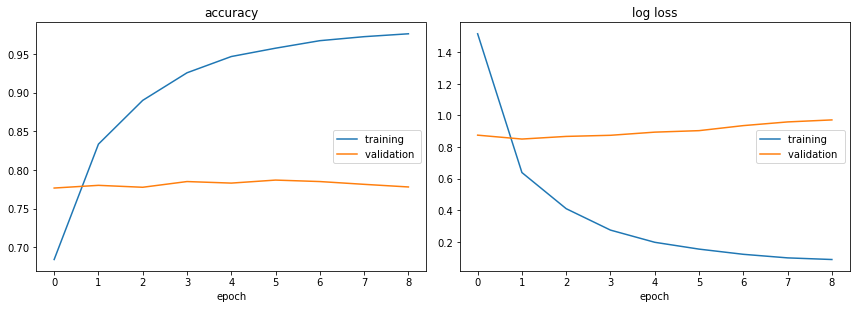

accuracy
	training         	 (min:    0.684, max:    0.976, cur:    0.976)
	validation       	 (min:    0.777, max:    0.787, cur:    0.778)
log loss
	training         	 (min:    0.089, max:    1.517, cur:    0.089)
	validation       	 (min:    0.851, max:    0.972, cur:    0.972)
Epoch: 8 Train acc: 0.9764 Val acc: 0.7781 Time 83197.0282


In [ ]:
# Hyperparameters

# MODELS
import torchvision.models as models
model = models.wide_resnet101_2(pretrained=True)


lr=1e-2
momentum=0.5
weight_decay = 0
workers = 0

 # Edit last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 200)


model = model.to(device)
train_model_augmented('wide_resnet101_2')

csv_out = 0
if (csv_out == 1):
    PATH = './' + str(4) + 'wide_resnet101_2' + '_model.pth'
    model.load_state_dict(torch.load(PATH))
    model = model.to(device)
    
    import pandas as pd

    def test_result(model, data_loader):
        
        model.eval()
        y_preds, y_numbers = [],[]
        for X, y in data_loader:
            with torch.no_grad():
                X, y= X.to(device), y.to(device)
                a2 = model(X)
                y_pred = F.log_softmax(a2, dim=1).max(1)[1]
                y_numbers.append(y.cpu().numpy())
                y_preds.append(y_pred.cpu().numpy())
                
        return np.array(y_preds), np.array(y_numbers).astype(int)


test_file_path = './test'